### 07a. Testing Modality-Based Demand Models

This notebook aims to model and predict healthcare demand based on patient demographics and clinical indicators, specifically focusing on different **modalities** of service. The primary goal is to evaluate various statistical and machine learning models for their ability to predict demand, with a focus on the following input features:

- **Age segments** (e.g., binned or continuous)  
- **Patient source**  
- **Elective vs emergency flag**  
- **Cancer flag**

We will begin with simple aggregate modeling and progressively test more complex models:

1. **Naïve mean** – simple average demand per segment  
2. **GLM** – Generalized Linear Model  
3. **GLM with interactions** – e.g., age × cancer flag  
4. **GAM** – Generalized Additive Model  
5. **Random Forest** – tree-based machine learning model

Each model will be tested per modality, and performance will be evaluated using an 80/20 train-test split with the following metrics:

- Mean Absolute Error (MAE)  
- Root Mean Squared Error (RMSE)  
- R² or Deviance explained (for GLM/GAM)

The overall aim is to understand which modeling approach best captures the relationship between demographic/clinical inputs and demand, and how this varies by modality.


In [1]:
!pip install pygam

In [5]:
import sys
!{sys.executable} -m pip install pygam


  Using cached pygam-0.9.1-py3-none-any.whl.metadata (7.1 kB)
  Using cached progressbar2-4.5.0-py3-none-any.whl.metadata (16 kB)
  Using cached python_utils-3.9.1-py2.py3-none-any.whl.metadata (9.8 kB)
  Using cached numpy-1.26.4-cp310-cp310-macosx_10_9_x86_64.whl.metadata (61 kB)
Using cached pygam-0.9.1-py3-none-any.whl (522 kB)
Using cached progressbar2-4.5.0-py3-none-any.whl (57 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 8.7 MB/s eta 0:00:000:00:010:00:0104
Using cached numpy-1.26.4-cp310-cp310-macosx_10_9_x86_64.whl (20.6 MB)
Using cached python_utils-3.9.1-py2.py3-none-any.whl (32 kB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.6
    Uninstalling numpy-2.2.6:
      Successfully uninstalled numpy-2.2.6
  Attempting uninstall: scipy╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/5 [numpy]
    Found existing installation: scipy 1.15.2━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/5 [numpy]
    Uninstalling scipy-1.15.2:╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/5 [nump

In [12]:
# Data Handling
import pandas as pd
import numpy as np
import os

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling - GLM, GAM, RF
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from pygam import LinearGAM, s, f  # For Generalized Additive Models

# Model Evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Warnings
import warnings
warnings.filterwarnings("ignore")

# Optional - for hierarchical modeling if extended
# import pymc3 as pm  # Uncomment if you plan to use Bayesian hierarchical models


In [14]:
# Set base path
base_path = "/Users/rosstaylor/Downloads/Research Project/Code Folder/nhs-diagnostics-dids-eda/nhs-dids-explorer/data/processed"

# File paths
endo_master_path = os.path.join(base_path, "endo_master.csv")
modality_counts_path = os.path.join(base_path, "modality_procedure_counts_by_age_band_2024.csv")
population_path = os.path.join(base_path, "south_west_population_2024.csv")

# Load CSVs
endo_master_df = pd.read_csv(endo_master_path)
modality_counts_df = pd.read_csv(modality_counts_path)
population_df = pd.read_csv(population_path)

# Display basic checks
print("Endoscopy Master Data - Columns:")
print(endo_master_df.columns.tolist())
print("\nHead:")
print(endo_master_df.head(), "\n")

print("Modality Procedure Counts by Age Band 2024 - Columns:")
print(modality_counts_df.columns.tolist())
print("\nHead:")
print(modality_counts_df.head(), "\n")

print("South West Population 2024 - Columns:")
print(population_df.columns.tolist())
print("\nHead:")
print(population_df.head())

Endoscopy Master Data - Columns:
['icb_code', 'icb_name', 'lsoa_code', 'nhs_region', 'site_code', 'site_name', 'provider_code', 'provider_name', 'activity_month', 'financial_year', 'financial_month', 'test_date', 'age', 'sex', 'modality', 'sub_modality', 'procedure_name', 'referral_type', 'patient_source', 'cancer_flag', 'subcancer_flag', 'referring_org_code', 'referring_org_name', 'age_band', 'age_mid', 'modality_clean', 'ps_bucket', 'is_ct', 'is_mri', 'is_endo']

Head:
  icb_code                icb_name  lsoa_code  \
0      11X  NHS SOMERSET ICB - 11X  E01029316   
1      11X  NHS SOMERSET ICB - 11X  E01029134   
2      11X  NHS SOMERSET ICB - 11X  E01029331   
3      11X  NHS SOMERSET ICB - 11X  E01029052   
4      11X  NHS SOMERSET ICB - 11X  E01029205   

                             nhs_region site_code  \
0  Abdominal structure (body structure)     RH5A8   
1  Abdominal structure (body structure)     RA7C2   
2  Abdominal structure (body structure)     RH5A8   
3  Abdominal stru

In [24]:
# Naïve Mean Model (Aggregate Baseline)

# Load modality procedure counts
modality_counts_df = pd.read_csv(modality_counts_path)

# Define 2024 population projection by age band
age_band_population = pd.DataFrame({
    "age_band": [
        "0-4", "5-9", "10-14", "15-19", "20-24", "25-29", "30-34", "35-39",
        "40-44", "45-49", "50-54", "55-59", "60-64", "65-69", "70-74",
        "75-79", "80-84", "85+"
    ],
    "population_2024": [
        283792, 322018, 331416, 324765, 342425, 342688, 367510, 355513,
        341210, 362553, 413048, 423510, 376552, 337298, 357074,
        266939, 181501, 183436
    ]
})

# Step 1: Extract age_band and Endoscopy_Total
endoscopy_df = modality_counts_df[['age_band', 'Endoscopy_Total']].copy()

# Step 2: Merge with population data
endoscopy_df = endoscopy_df.merge(age_band_population, on='age_band', how='left')

# Step 3: Calculate demand per 10k and per 1k
endoscopy_df['endoscopy_demand_per_10k'] = (
    endoscopy_df['Endoscopy_Total'] / endoscopy_df['population_2024']
) * 10000

endoscopy_df['endoscopy_demand_per_1k'] = (
    endoscopy_df['Endoscopy_Total'] / endoscopy_df['population_2024']
) * 1000

# Optional: Round for readability
endoscopy_df[['endoscopy_demand_per_10k', 'endoscopy_demand_per_1k']] = \
    endoscopy_df[['endoscopy_demand_per_10k', 'endoscopy_demand_per_1k']].round(2)

# Display result
print(endoscopy_df)


   age_band  Endoscopy_Total  population_2024  endoscopy_demand_per_10k  \
0       0-4               11           283792                      0.39   
1       5-9                5           322018                      0.16   
2     10-14               13           331416                      0.39   
3     15-19               40           324765                      1.23   
4     20-24               55           342425                      1.61   
5     25-29              133           342688                      3.88   
6     30-34              168           367510                      4.57   
7     35-39              219           355513                      6.16   
8     40-44              242           341210                      7.09   
9     45-49              277           362553                      7.64   
10    50-54              404           413048                      9.78   
11    55-59              597           423510                     14.10   
12    60-64              

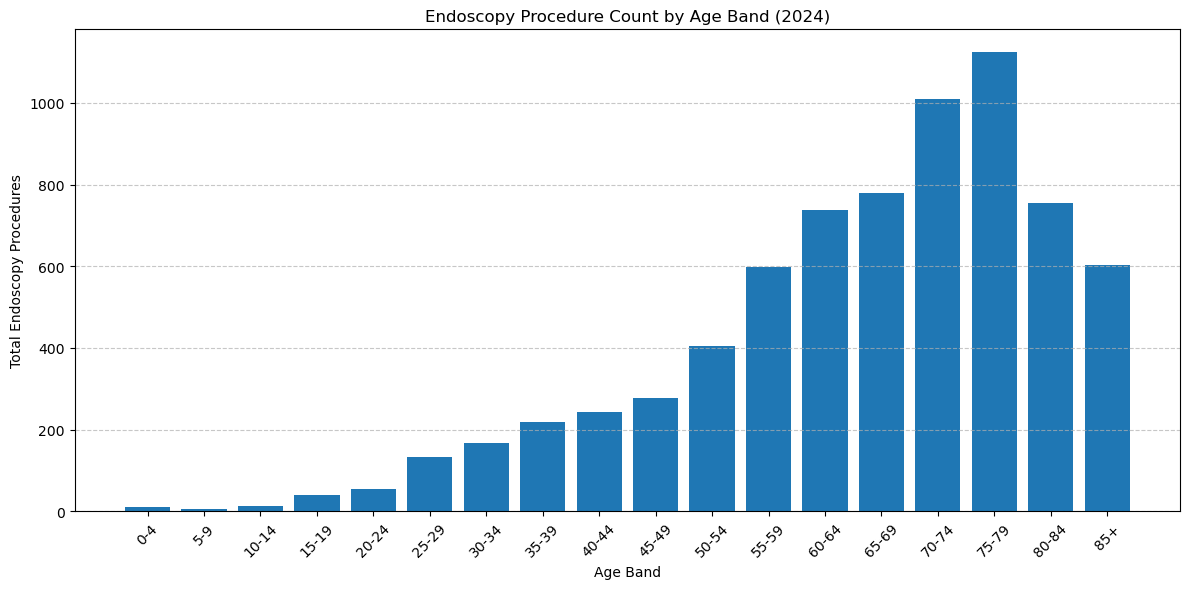

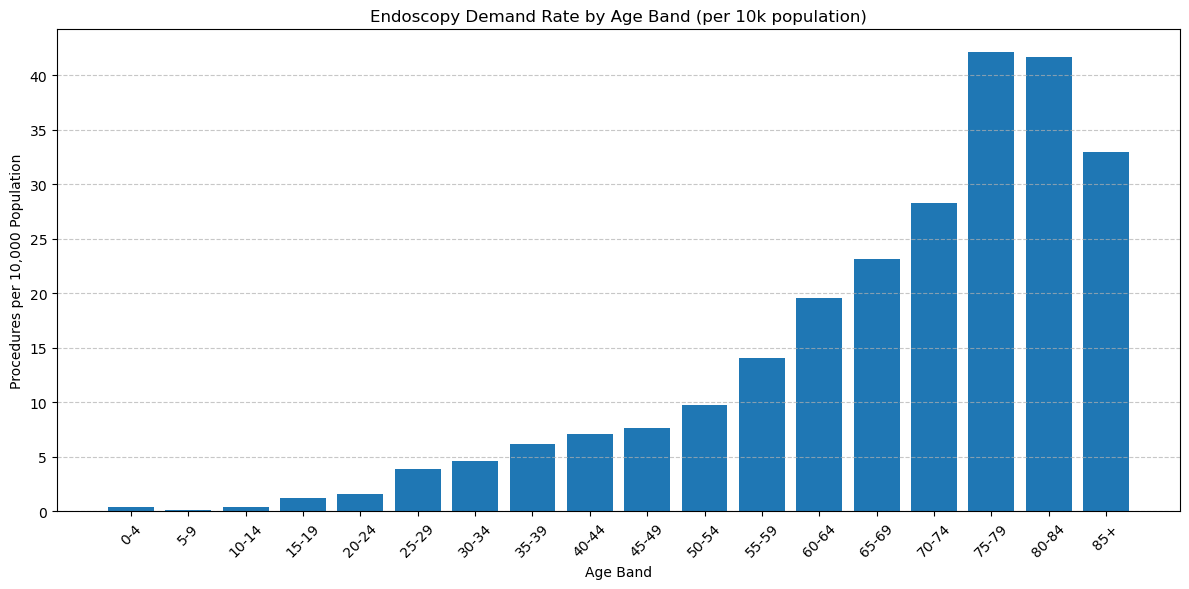

In [41]:
# Vis

plt.figure(figsize=(12, 6))
plt.bar(endoscopy_df['age_band'], endoscopy_df['Endoscopy_Total'])
plt.xlabel('Age Band')
plt.ylabel('Total Endoscopy Procedures')
plt.title('Endoscopy Procedure Count by Age Band (2024)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.bar(endoscopy_df['age_band'], endoscopy_df['endoscopy_demand_per_10k'])
plt.xlabel('Age Band')
plt.ylabel('Procedures per 10,000 Population')
plt.title('Endoscopy Demand Rate by Age Band (per 10k population)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



Sum of demand PDF over age bands: 1.000000


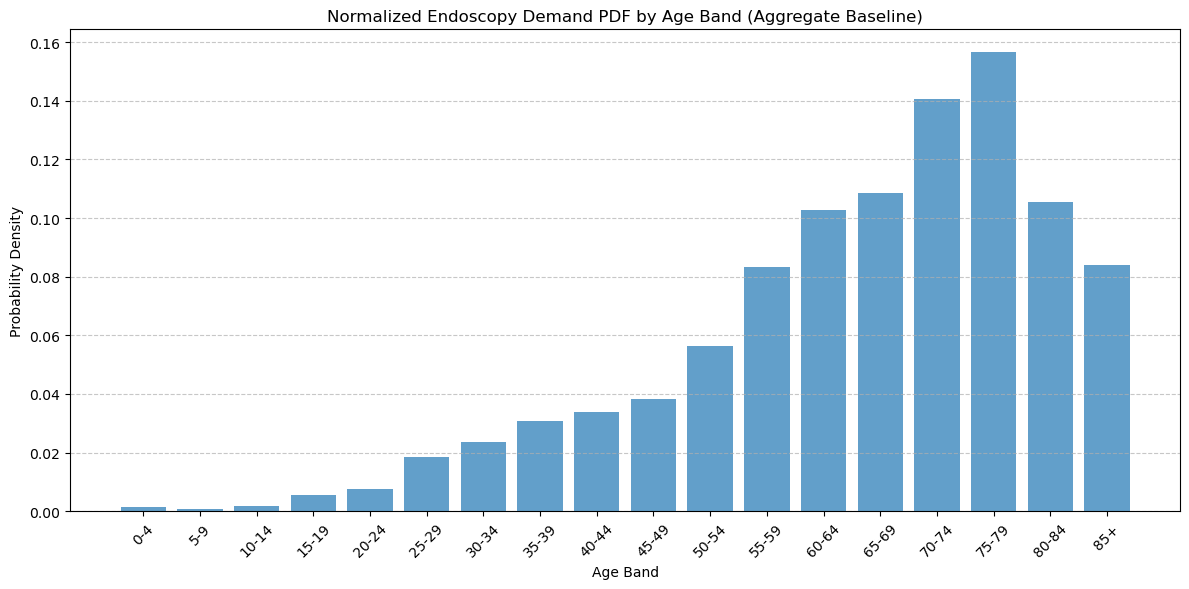

In [232]:
# Step 1: Calculate total demand per band (demand per 1k * population / 1000)
endoscopy_df['total_demand'] = (endoscopy_df['endoscopy_demand_per_1k'] * endoscopy_df['population_2024']) / 1000

# Step 2: Normalize total demand to create PDF over age bands
total_demand_sum = endoscopy_df['total_demand'].sum()
endoscopy_df['demand_pdf'] = endoscopy_df['total_demand'] / total_demand_sum

# Step 3: Confirm sum to 1
print(f"Sum of demand PDF over age bands: {endoscopy_df['demand_pdf'].sum():.6f}")

# Step 4: Visualise the PDF
plt.figure(figsize=(12, 6))
plt.bar(endoscopy_df['age_band'], endoscopy_df['demand_pdf'], alpha=0.7)
plt.xlabel('Age Band')
plt.ylabel('Probability Density')
plt.title('Normalized Endoscopy Demand PDF by Age Band (Aggregate Baseline)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [32]:
#  Naïve Model (Continuous Age)

# Step 1: Filter Endoscopy records
endo_df = endo_master_df[endo_master_df['is_endo'] == 1].copy()

# Step 2: Load population data (expects columns: 'age', 'population')
population_df = pd.read_csv(population_path)
population_df.rename(columns={'population': 'population_2024'}, inplace=True)

# Step 3: Count endoscopy procedures by age
endo_by_age = endo_df.groupby('age').size().reset_index(name='Endoscopy_Total')

# Step 4: Merge with population data
merged_df = endo_by_age.merge(population_df, on='age', how='left')

# Step 5: Calculate demand per 10,000 and per 1,000
merged_df['endoscopy_demand_per_10k'] = (merged_df['Endoscopy_Total'] / merged_df['population_2024']) * 10000
merged_df['endoscopy_demand_per_1k'] = (merged_df['Endoscopy_Total'] / merged_df['population_2024']) * 1000

# Step 6: Round for readability
merged_df[['endoscopy_demand_per_10k', 'endoscopy_demand_per_1k']] = \
    merged_df[['endoscopy_demand_per_10k', 'endoscopy_demand_per_1k']].round(2)

# Optional: Sort by age for better readability
merged_df.sort_values('age', inplace=True)

# View result
print(merged_df.head())

   age  Endoscopy_Total  population_2024  endoscopy_demand_per_10k  \
0    0                3          52166.0                      0.58   
1    1                1          54517.0                      0.18   
2    2                3          56664.0                      0.53   
3    3                4          57911.0                      0.69   
4    5                1          61960.0                      0.16   

   endoscopy_demand_per_1k  
0                     0.06  
1                     0.02  
2                     0.05  
3                     0.07  
4                     0.02  


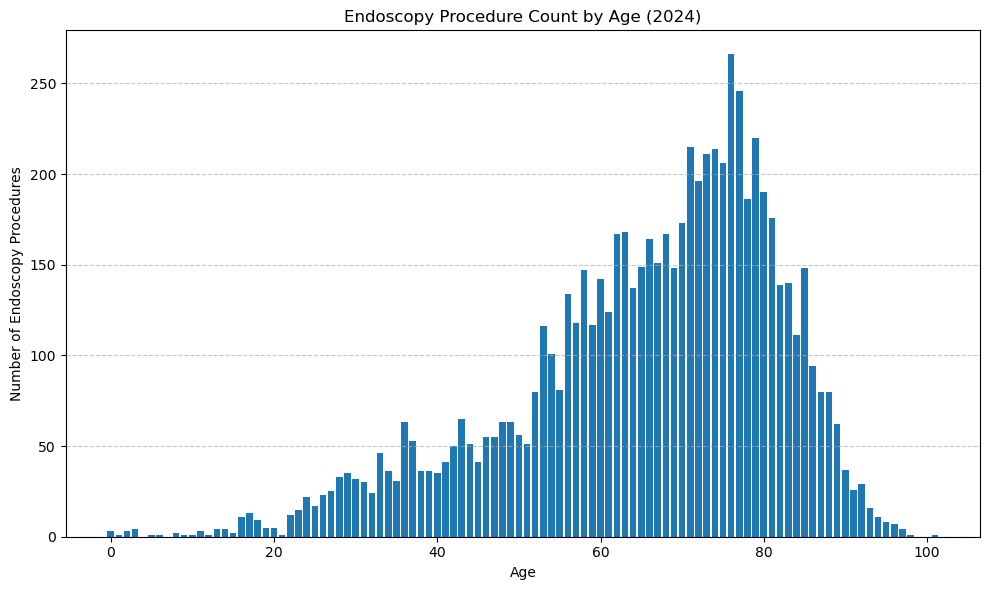

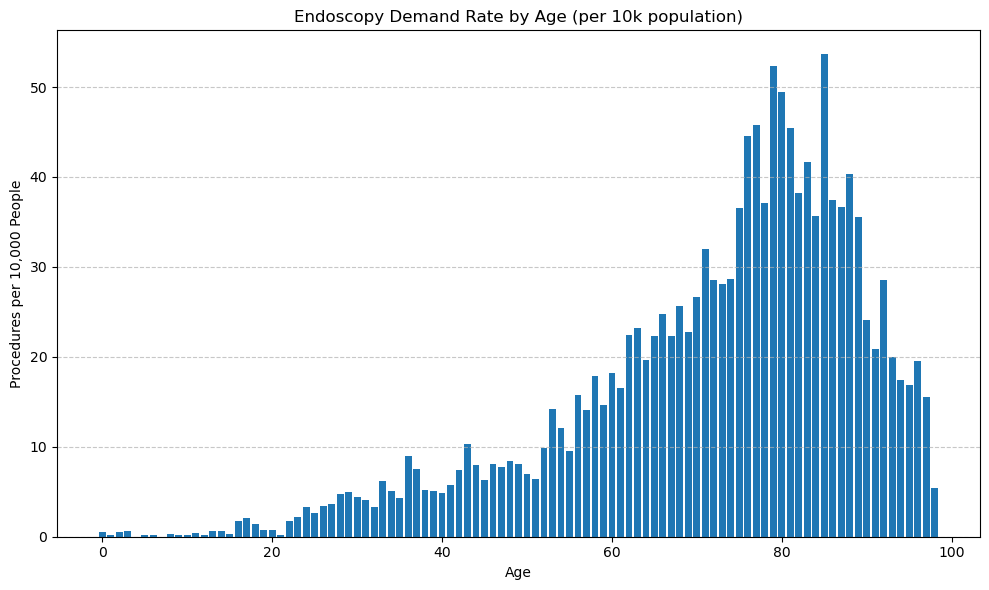

In [162]:
# Histogram of total endoscopy procedures by age
plt.figure(figsize=(10, 6))
plt.bar(merged_df['age'], merged_df['Endoscopy_Total'], width=0.8)
plt.xlabel('Age')
plt.ylabel('Number of Endoscopy Procedures')
plt.title('Endoscopy Procedure Count by Age (2024)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Histogram of endoscopy demand rate per 10,000 population by age
plt.figure(figsize=(10, 6))
plt.bar(merged_df['age'], merged_df['endoscopy_demand_per_10k'], width=0.8)
plt.xlabel('Age')
plt.ylabel('Procedures per 10,000 People')
plt.title('Endoscopy Demand Rate by Age (per 10k population)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



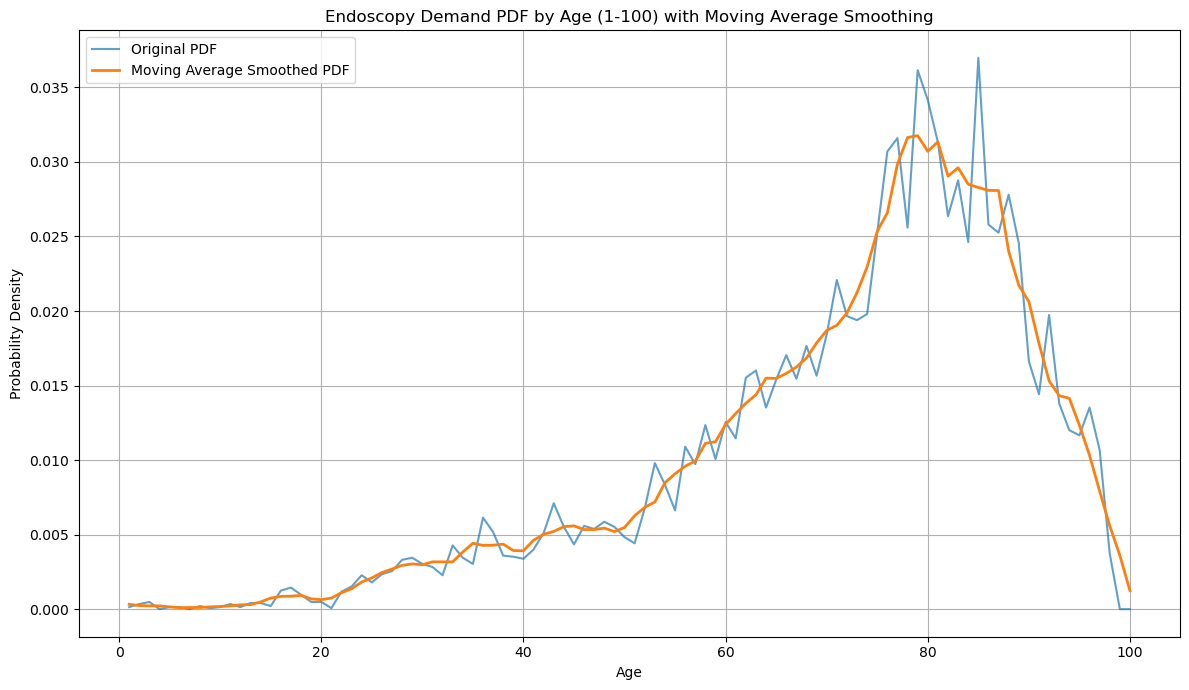

In [243]:
# Prepare full age range and merge
full_age_range = pd.DataFrame({'age': np.arange(1, 101)})
merged_full = full_age_range.merge(merged_df[['age', 'endoscopy_demand_per_1k']], on='age', how='left')
merged_full['endoscopy_demand_per_1k'].fillna(0, inplace=True)

# Normalize to get PDF
demand = merged_full['endoscopy_demand_per_1k'].values
pdf = demand / demand.sum()
merged_full['demand_pdf'] = pdf

# Apply moving average smoothing (window size = 5)
window_size = 5
smoothed_pdf = merged_full['demand_pdf'].rolling(window=window_size, center=True, min_periods=1).mean()
merged_full['smoothed_pdf'] = smoothed_pdf

# Plot raw and smoothed PDFs
plt.figure(figsize=(12, 7))
plt.plot(merged_full['age'], merged_full['demand_pdf'], label='Original PDF', alpha=0.7)
plt.plot(merged_full['age'], merged_full['smoothed_pdf'], label='Moving Average Smoothed PDF', linewidth=2)
plt.xlabel('Age')
plt.ylabel('Probability Density')
plt.title('Endoscopy Demand PDF by Age (1-100) with Moving Average Smoothing')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [212]:
# Step 7: Calculate % of total endoscopies for age range 80–100
total_endo = merged_df['Endoscopy_Total'].sum()
endo_80_100 = merged_df[merged_df['age'].between(85, 100)]['Endoscopy_Total'].sum()
percentage_80_100 = (endo_80_100 / total_endo) * 100

print(f"Percentage of endoscopies for ages 80–100: {percentage_80_100:.2f}%")


Percentage of endoscopies for ages 80–100: 8.41%


Poisson GLM          | MAE: 0.63 | RMSE: 1.04 | R²: 0.490
Random Forest        | MAE: 0.09 | RMSE: 0.14 | R²: 0.991


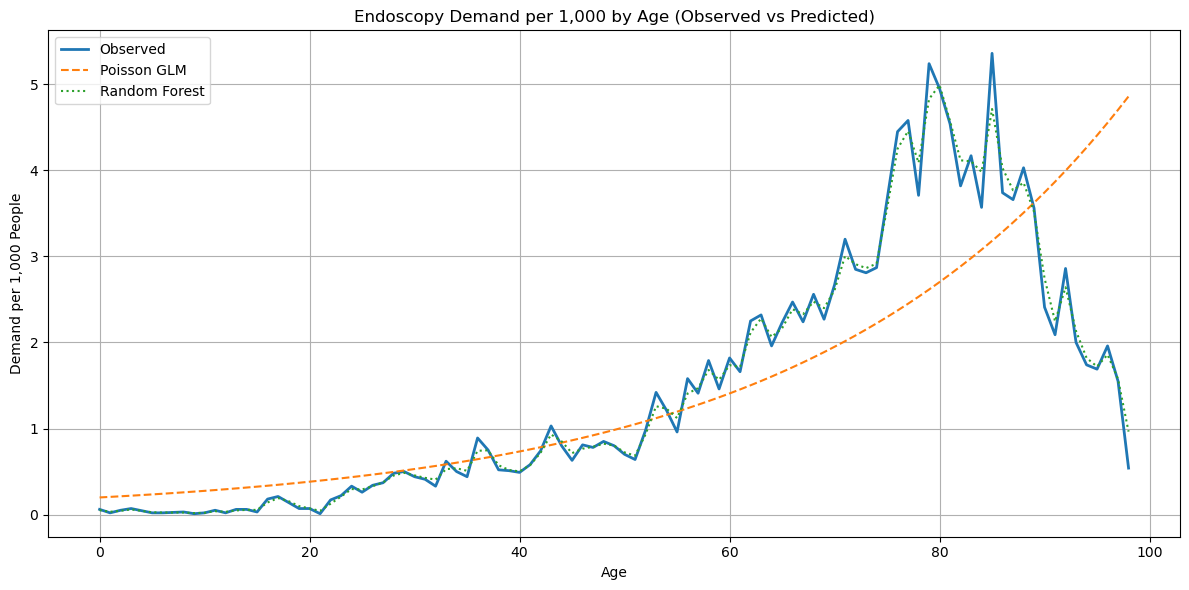

In [158]:
# ----------------------------------------------------------
#  Predicting Endoscopy Demand Rate per 1,000 People by Age
# ----------------------------------------------------------

# Step 1: Prepare data
model_df = merged_df.copy()
model_df.dropna(subset=["endoscopy_demand_per_1k"], inplace=True)

# Step 2: Poisson GLM (Statsmodels)
glm_model = smf.glm(
    formula="endoscopy_demand_per_1k ~ age",
    data=model_df,
    family=sm.families.Poisson()
).fit()

model_df["predicted_glm"] = glm_model.predict(model_df)

# Step 3: Random Forest (Sklearn)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(model_df[["age"]], model_df["endoscopy_demand_per_1k"])
model_df["predicted_rf"] = rf_model.predict(model_df[["age"]])

# Step 4: Evaluation
def evaluate(true, pred, name):
    mae = mean_absolute_error(true, pred)
    rmse = np.sqrt(mean_squared_error(true, pred))  # older sklearn compatible
    r2 = r2_score(true, pred)
    print(f"{name:<20} | MAE: {mae:.2f} | RMSE: {rmse:.2f} | R²: {r2:.3f}")

evaluate(model_df["endoscopy_demand_per_1k"], model_df["predicted_glm"], "Poisson GLM")
evaluate(model_df["endoscopy_demand_per_1k"], model_df["predicted_rf"],  "Random Forest")

# Step 5: Visualise
plt.figure(figsize=(12, 6))
sns.lineplot(data=model_df, x="age", y="endoscopy_demand_per_1k", label="Observed", linewidth=2)
sns.lineplot(data=model_df, x="age", y="predicted_glm", label="Poisson GLM", linestyle="--")
sns.lineplot(data=model_df, x="age", y="predicted_rf", label="Random Forest", linestyle=":")
plt.title("Endoscopy Demand per 1,000 by Age (Observed vs Predicted)")
plt.ylabel("Demand per 1,000 People")
plt.xlabel("Age")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Poisson GLM          | MAE: 0.21 | RMSE: 0.36 | R²: 0.933
Random Forest        | MAE: 0.06 | RMSE: 0.10 | R²: 0.995


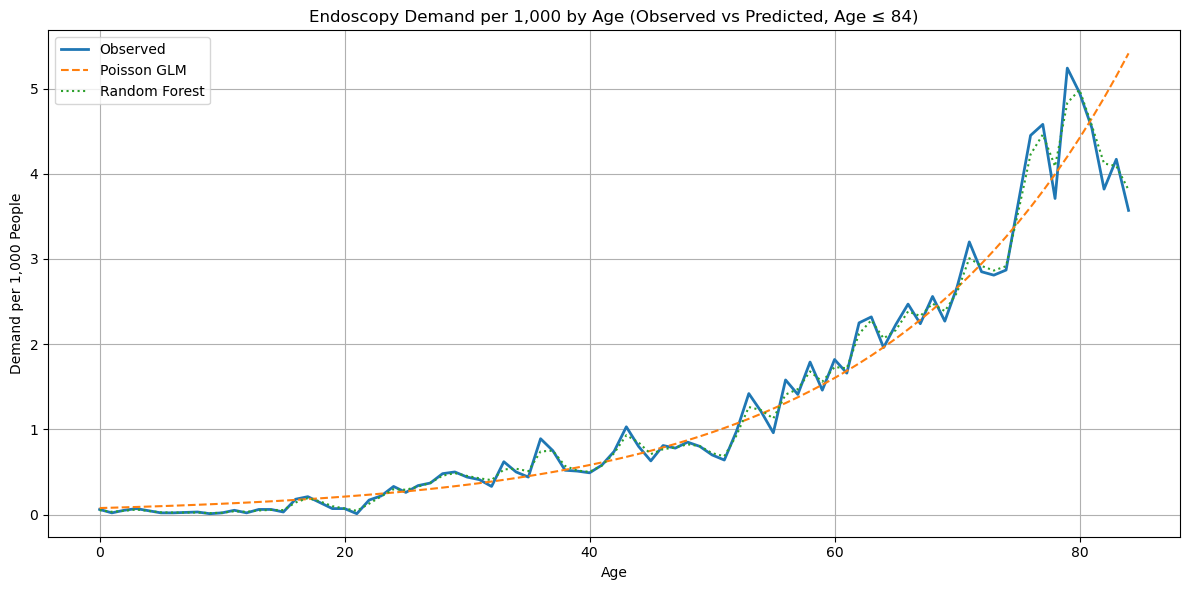

In [184]:
# ----------------------------------------------------------
#  Modelling · Predict Endoscopy Demand per 1,000 People by Age (Age ≤ 84)
# ----------------------------------------------------------

import statsmodels.formula.api as smf
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Step 1: Filter and prepare data
endo_model_df = merged_df.copy()
endo_model_df = endo_model_df[endo_model_df["age"] <= 84]  # Cap age to ≤84
endo_model_df.dropna(subset=["endoscopy_demand_per_1k"], inplace=True)

# Step 2: Poisson GLM
glm_endo_model = smf.glm(
    formula="endoscopy_demand_per_1k ~ age",
    data=endo_model_df,
    family=sm.families.Poisson()
).fit()

# Generate predictions + confidence intervals
predictions_glm = glm_endo_model.get_prediction(endo_model_df)
pred_summary = predictions_glm.summary_frame(alpha=0.05)  # 95% CI

# Add to DataFrame
endo_model_df["predicted_glm_1k"] = pred_summary["mean"]
endo_model_df["glm_ci_lower"] = pred_summary["mean_ci_lower"]
endo_model_df["glm_ci_upper"] = pred_summary["mean_ci_upper"]

# Step 3: Random Forest
rf_endo_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_endo_model.fit(endo_model_df[["age"]], endo_model_df["endoscopy_demand_per_1k"])
endo_model_df["predicted_rf_1k"] = rf_endo_model.predict(endo_model_df[["age"]])

# Step 4: Evaluation Function
def evaluate_predictions(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name:<20} | MAE: {mae:.2f} | RMSE: {rmse:.2f} | R²: {r2:.3f}")

evaluate_predictions(endo_model_df["endoscopy_demand_per_1k"], endo_model_df["predicted_glm_1k"], "Poisson GLM")
evaluate_predictions(endo_model_df["endoscopy_demand_per_1k"], endo_model_df["predicted_rf_1k"],  "Random Forest")

# Step 5: Visualisation
plt.figure(figsize=(12, 6))
sns.lineplot(data=endo_model_df, x="age", y="endoscopy_demand_per_1k", label="Observed", linewidth=2)
sns.lineplot(data=endo_model_df, x="age", y="predicted_glm_1k", label="Poisson GLM", linestyle="--")
sns.lineplot(data=endo_model_df, x="age", y="predicted_rf_1k", label="Random Forest", linestyle=":")
plt.title("Endoscopy Demand per 1,000 by Age (Observed vs Predicted, Age ≤ 84)")
plt.ylabel("Demand per 1,000 People")
plt.xlabel("Age")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


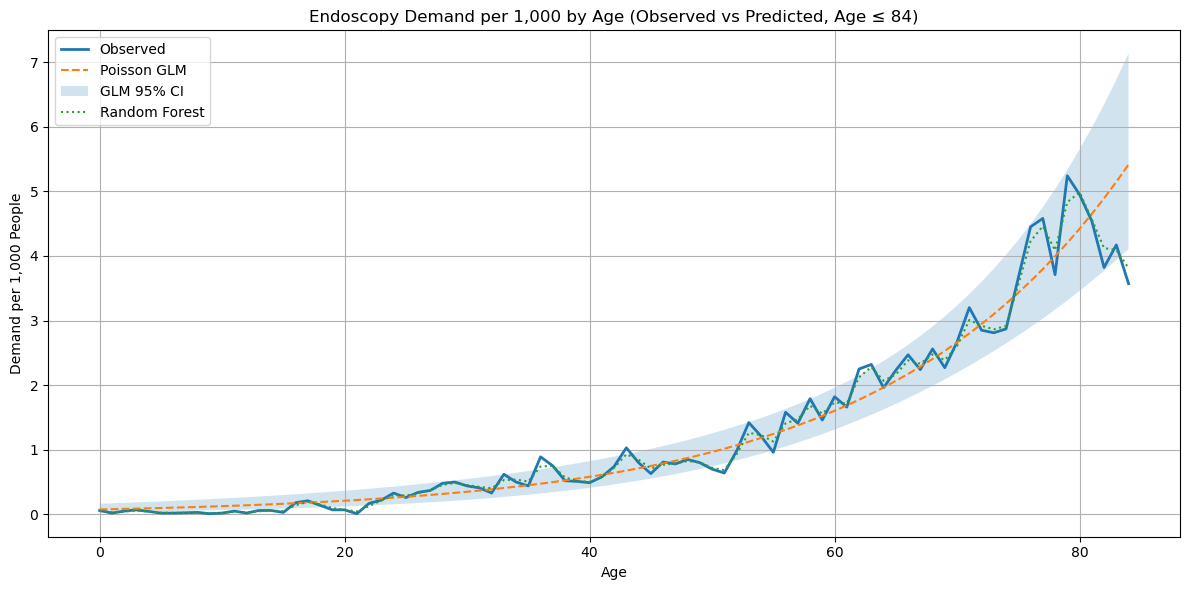

In [186]:
plt.figure(figsize=(12, 6))

# Sort by age for cleaner plotting
plot_df = endo_model_df.sort_values(by="age")

# Plot observed
sns.lineplot(data=plot_df, x="age", y="endoscopy_demand_per_1k", label="Observed", linewidth=2)

# Plot Poisson GLM predictions and CI
sns.lineplot(data=plot_df, x="age", y="predicted_glm_1k", label="Poisson GLM", linestyle="--")
plt.fill_between(
    plot_df["age"],
    plot_df["glm_ci_lower"],
    plot_df["glm_ci_upper"],
    alpha=0.2,
    label="GLM 95% CI"
)

# Plot Random Forest predictions
sns.lineplot(data=plot_df, x="age", y="predicted_rf_1k", label="Random Forest", linestyle=":")

plt.title("Endoscopy Demand per 1,000 by Age (Observed vs Predicted, Age ≤ 84)")
plt.ylabel("Demand per 1,000 People")
plt.xlabel("Age")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Poisson GLM          | MAE: 0.21 | RMSE: 0.36 | R²: 0.933
Random Forest        | MAE: 0.06 | RMSE: 0.10 | R²: 0.995
Ensemble             | MAE: 0.13 | RMSE: 0.22 | R²: 0.975


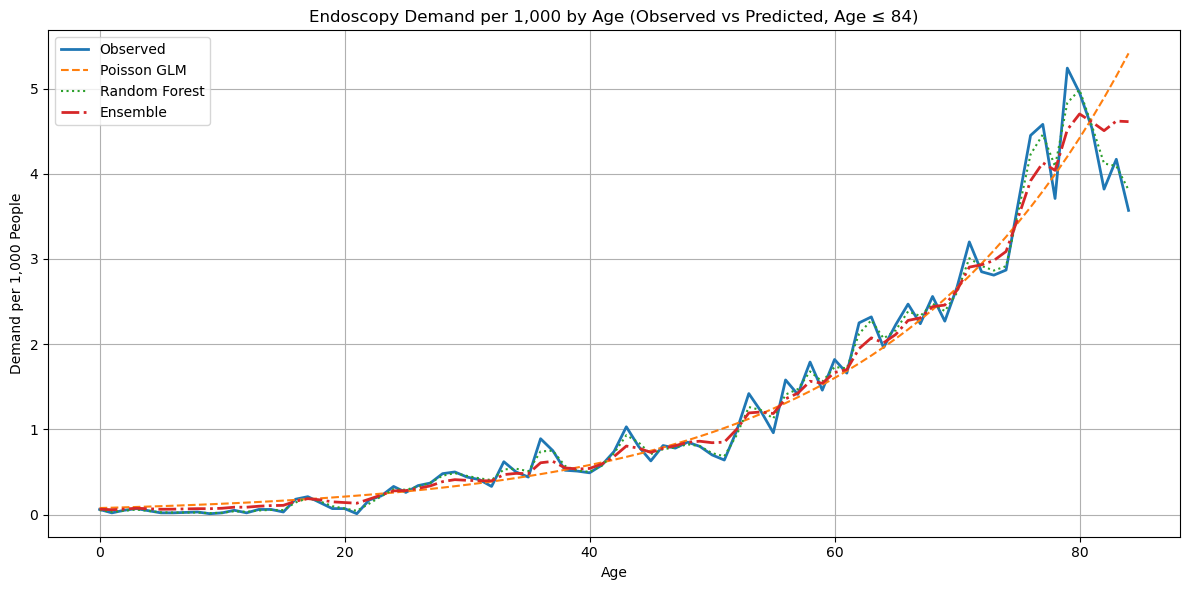

In [221]:
# ----------------------------------------------------------
#  Modelling · Predict Endoscopy Demand per 1,000 People by Age (Age ≤ 84)
# ----------------------------------------------------------

import statsmodels.formula.api as smf
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Step 1: Filter and prepare data
endo_model_df = merged_df.copy()
endo_model_df = endo_model_df[endo_model_df["age"] <= 84]
endo_model_df.dropna(subset=["endoscopy_demand_per_1k"], inplace=True)

# Step 2: Poisson GLM
glm_endo_model = smf.glm(
    formula="endoscopy_demand_per_1k ~ age",
    data=endo_model_df,
    family=sm.families.Poisson()
).fit()

predictions_glm = glm_endo_model.get_prediction(endo_model_df)
pred_summary = predictions_glm.summary_frame(alpha=0.05)

endo_model_df["predicted_glm_1k"] = pred_summary["mean"]
endo_model_df["glm_ci_lower"] = pred_summary["mean_ci_lower"]
endo_model_df["glm_ci_upper"] = pred_summary["mean_ci_upper"]

# Step 3: Random Forest
rf_endo_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_endo_model.fit(endo_model_df[["age"]], endo_model_df["endoscopy_demand_per_1k"])
endo_model_df["predicted_rf_1k"] = rf_endo_model.predict(endo_model_df[["age"]])

# Step 4: Ensemble (Simple Average)
endo_model_df["predicted_ensemble_1k"] = (
    0.5 * endo_model_df["predicted_glm_1k"] + 0.5 * endo_model_df["predicted_rf_1k"]
)

# Step 5: Evaluation
def evaluate_predictions(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name:<20} | MAE: {mae:.2f} | RMSE: {rmse:.2f} | R²: {r2:.3f}")

evaluate_predictions(endo_model_df["endoscopy_demand_per_1k"], endo_model_df["predicted_glm_1k"], "Poisson GLM")
evaluate_predictions(endo_model_df["endoscopy_demand_per_1k"], endo_model_df["predicted_rf_1k"],  "Random Forest")
evaluate_predictions(endo_model_df["endoscopy_demand_per_1k"], endo_model_df["predicted_ensemble_1k"], "Ensemble")

# Step 6: Visualisation
plt.figure(figsize=(12, 6))
sns.lineplot(data=endo_model_df, x="age", y="endoscopy_demand_per_1k", label="Observed", linewidth=2)
sns.lineplot(data=endo_model_df, x="age", y="predicted_glm_1k", label="Poisson GLM", linestyle="--")
sns.lineplot(data=endo_model_df, x="age", y="predicted_rf_1k", label="Random Forest", linestyle=":")
sns.lineplot(data=endo_model_df, x="age", y="predicted_ensemble_1k", label="Ensemble", linestyle="-.", linewidth=2)
plt.title("Endoscopy Demand per 1,000 by Age (Observed vs Predicted, Age ≤ 84)")
plt.ylabel("Demand per 1,000 People")
plt.xlabel("Age")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Poisson GLM (85+ grouped) | MAE: 0.24 | RMSE: 0.46 | R²: 0.892
Random Forest (85+ grouped) | MAE: 0.07 | RMSE: 0.11 | R²: 0.994


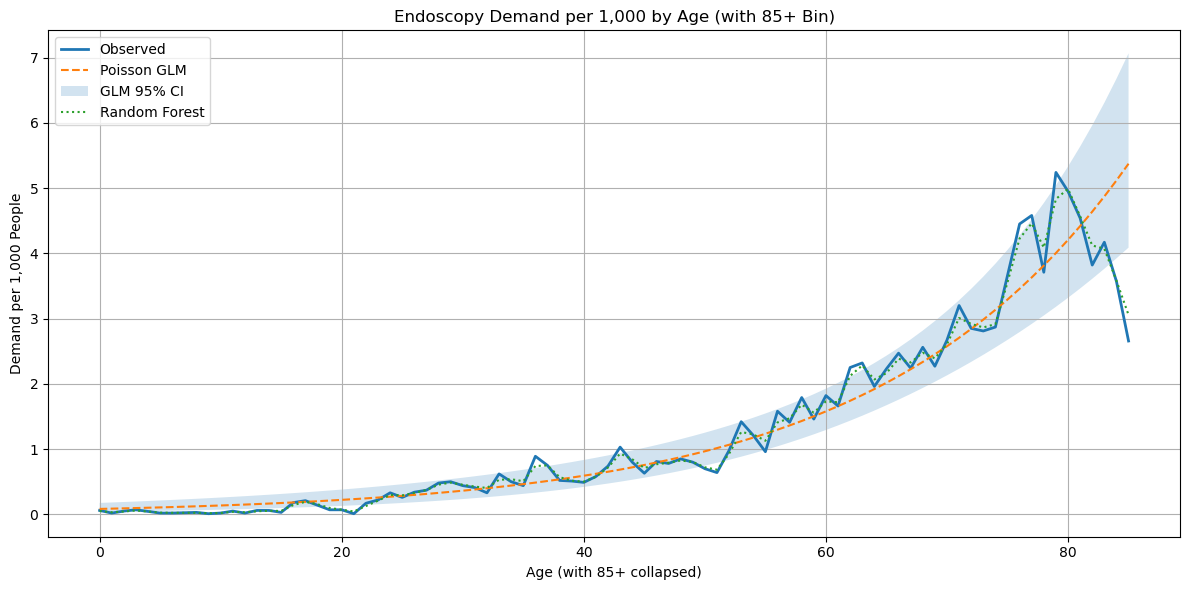

In [198]:
# ----------------------------------------------------------
#  Modelling · Predict Endoscopy Demand per 1,000 People by Age (with 85+ bin)
# ----------------------------------------------------------

import statsmodels.formula.api as smf
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Step 1: Filter and collapse age groups
endo_model_df2 = merged_df.copy()
endo_model_df2 = endo_model_df2.dropna(subset=["endoscopy_demand_per_1k"])
endo_model_df2["age_collapsed"] = endo_model_df2["age"].apply(lambda x: 85 if x > 84 else x)

# Re-aggregate: average demand per collapsed age group
grouped = (
    endo_model_df2
    .groupby("age_collapsed")["endoscopy_demand_per_1k"]
    .mean()
    .reset_index()
    .rename(columns={"age_collapsed": "age"})
)

# Step 2: Poisson GLM
glm_model2 = smf.glm(
    formula="endoscopy_demand_per_1k ~ age",
    data=grouped,
    family=sm.families.Poisson()
).fit()

# Generate predictions + CI
preds_glm2 = glm_model2.get_prediction(grouped)
pred_summary2 = preds_glm2.summary_frame(alpha=0.05)

grouped["predicted_glm_1k"] = pred_summary2["mean"]
grouped["glm_ci_lower"] = pred_summary2["mean_ci_lower"]
grouped["glm_ci_upper"] = pred_summary2["mean_ci_upper"]

# Step 3: Random Forest
rf_model2 = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model2.fit(grouped[["age"]], grouped["endoscopy_demand_per_1k"])
grouped["predicted_rf_1k"] = rf_model2.predict(grouped[["age"]])

# Step 4: Evaluation
def evaluate_predictions(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name:<25} | MAE: {mae:.2f} | RMSE: {rmse:.2f} | R²: {r2:.3f}")

evaluate_predictions(grouped["endoscopy_demand_per_1k"], grouped["predicted_glm_1k"], "Poisson GLM (85+ grouped)")
evaluate_predictions(grouped["endoscopy_demand_per_1k"], grouped["predicted_rf_1k"], "Random Forest (85+ grouped)")

# Step 5: Visualisation
plt.figure(figsize=(12, 6))
sns.lineplot(data=grouped, x="age", y="endoscopy_demand_per_1k", label="Observed", linewidth=2)
sns.lineplot(data=grouped, x="age", y="predicted_glm_1k", label="Poisson GLM", linestyle="--")
plt.fill_between(grouped["age"], grouped["glm_ci_lower"], grouped["glm_ci_upper"], alpha=0.2, label="GLM 95% CI")
sns.lineplot(data=grouped, x="age", y="predicted_rf_1k", label="Random Forest", linestyle=":")
plt.title("Endoscopy Demand per 1,000 by Age (with 85+ Bin)")
plt.ylabel("Demand per 1,000 People")
plt.xlabel("Age (with 85+ collapsed)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Poisson GLM (Smoothed)    | MAE: 0.63 | RMSE: 1.03 | R²: 0.499
Random Forest (Smoothed)  | MAE: 0.18 | RMSE: 0.29 | R²: 0.960
Ensemble (Smoothed)       | MAE: 0.40 | RMSE: 0.67 | R²: 0.785


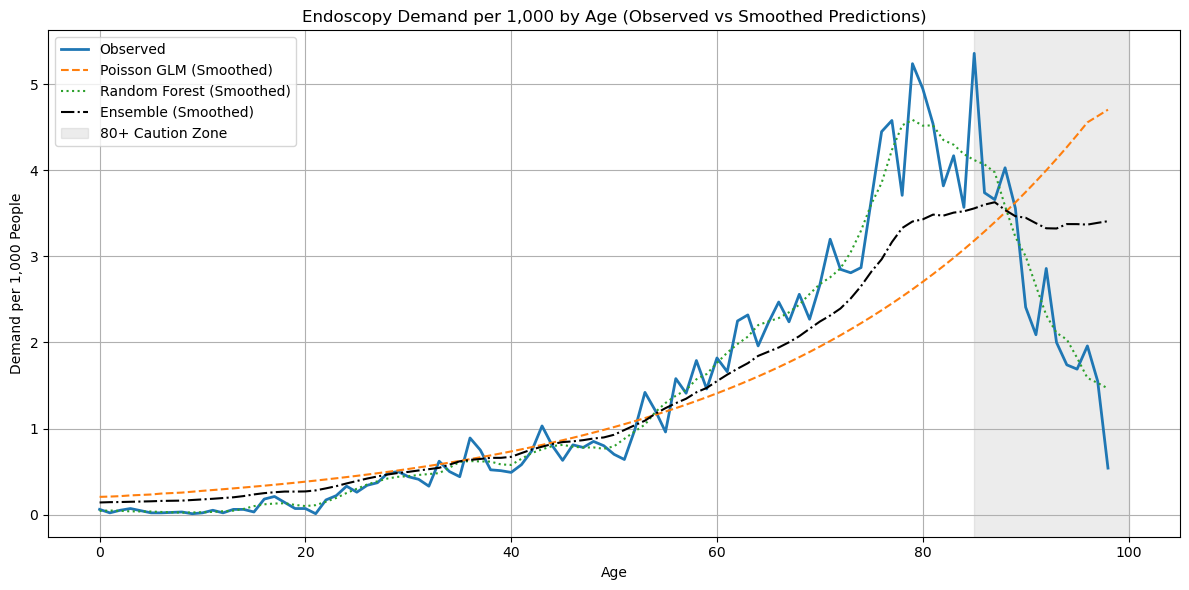

In [245]:
import pandas as pd

# ----------------------------------------------------------
#  Predicting Endoscopy Demand Rate per 1,000 People by Age
# ----------------------------------------------------------

# Step 1: Prepare data
model_df = merged_df.copy()
model_df.dropna(subset=["endoscopy_demand_per_1k"], inplace=True)

# Step 2: Poisson GLM (Statsmodels)
glm_model = smf.glm(
    formula="endoscopy_demand_per_1k ~ age",
    data=model_df,
    family=sm.families.Poisson()
).fit()
model_df["predicted_glm"] = glm_model.predict(model_df)

# Step 3: Random Forest (Sklearn)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(model_df[["age"]], model_df["endoscopy_demand_per_1k"])
model_df["predicted_rf"] = rf_model.predict(model_df[["age"]])

# Step 4: Ensemble Average
model_df["predicted_ensemble"] = 0.6 * model_df["predicted_glm"] + 0.4 * model_df["predicted_rf"]

# Step 5: Apply Moving Average Smoothing (window=5) to predictions
window_size = 5

for col in ["predicted_glm", "predicted_rf", "predicted_ensemble"]:
    model_df[f"{col}_smoothed"] = model_df[col].rolling(window=window_size, center=True, min_periods=1).mean()

# Step 6: Evaluation Function
def evaluate(true, pred, name):
    mae = mean_absolute_error(true, pred)
    rmse = np.sqrt(mean_squared_error(true, pred))
    r2 = r2_score(true, pred)
    print(f"{name:<25} | MAE: {mae:.2f} | RMSE: {rmse:.2f} | R²: {r2:.3f}")

# Step 7: Evaluate All Models (using smoothed predictions)
evaluate(model_df["endoscopy_demand_per_1k"], model_df["predicted_glm_smoothed"], "Poisson GLM (Smoothed)")
evaluate(model_df["endoscopy_demand_per_1k"], model_df["predicted_rf_smoothed"],  "Random Forest (Smoothed)")
evaluate(model_df["endoscopy_demand_per_1k"], model_df["predicted_ensemble_smoothed"], "Ensemble (Smoothed)")

# Step 8: Visualisation with smoothed predictions
plt.figure(figsize=(12, 6))
sns.lineplot(data=model_df, x="age", y="endoscopy_demand_per_1k", label="Observed", linewidth=2)
sns.lineplot(data=model_df, x="age", y="predicted_glm_smoothed", label="Poisson GLM (Smoothed)", linestyle="--")
sns.lineplot(data=model_df, x="age", y="predicted_rf_smoothed", label="Random Forest (Smoothed)", linestyle=":")
sns.lineplot(data=model_df, x="age", y="predicted_ensemble_smoothed", label="Ensemble (Smoothed)", linestyle="-.", color="black")

plt.axvspan(85, 100, color='grey', alpha=0.15, label="80+ Caution Zone")
plt.title("Endoscopy Demand per 1,000 by Age (Observed vs Smoothed Predictions)")
plt.ylabel("Demand per 1,000 People")
plt.xlabel("Age")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Poisson GLM (Smoothed)    | MAE: 0.63 | RMSE: 1.03 | R²: 0.499
Random Forest (Smoothed)  | MAE: 0.18 | RMSE: 0.29 | R²: 0.960
Ensemble (Smoothed)       | MAE: 0.40 | RMSE: 0.67 | R²: 0.785


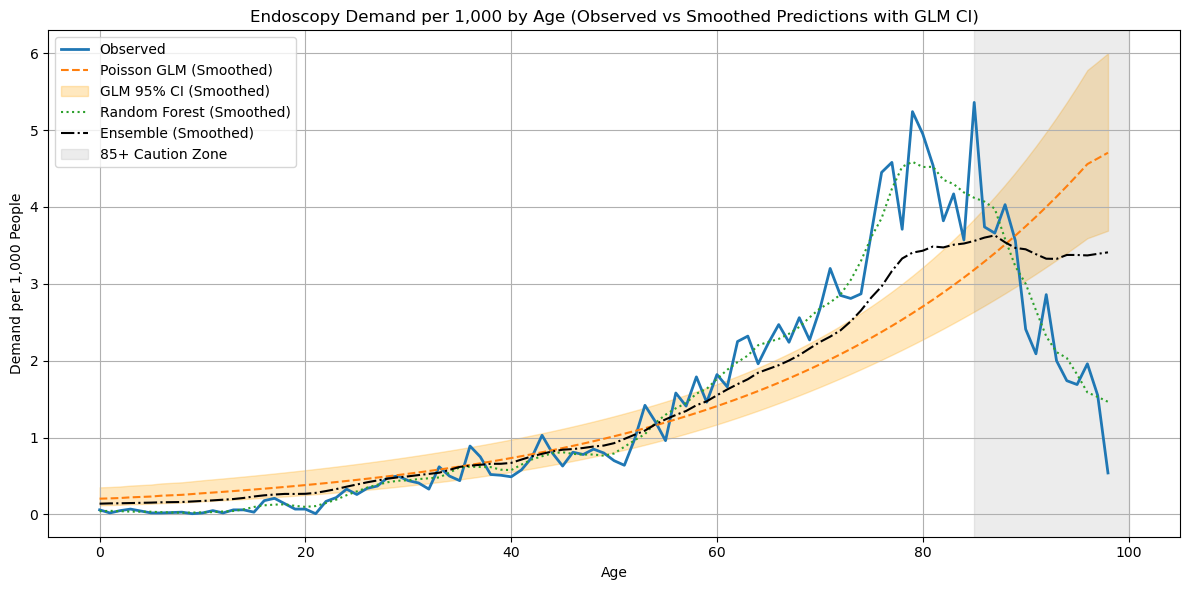

In [249]:
import statsmodels.formula.api as smf
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Step 1: Prepare data
model_df = merged_df.copy()
model_df.dropna(subset=["endoscopy_demand_per_1k"], inplace=True)

# Step 2: Poisson GLM (Statsmodels)
glm_model = smf.glm(
    formula="endoscopy_demand_per_1k ~ age",
    data=model_df,
    family=sm.families.Poisson()
).fit()
model_df["predicted_glm"] = glm_model.predict(model_df)

# Get 95% confidence intervals for GLM predictions
predictions_glm = glm_model.get_prediction(model_df)
pred_summary = predictions_glm.summary_frame(alpha=0.05)  # 95% CI
model_df["glm_ci_lower"] = pred_summary["mean_ci_lower"]
model_df["glm_ci_upper"] = pred_summary["mean_ci_upper"]

# Step 3: Random Forest (Sklearn)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(model_df[["age"]], model_df["endoscopy_demand_per_1k"])
model_df["predicted_rf"] = rf_model.predict(model_df[["age"]])

# Step 4: Ensemble Average
model_df["predicted_ensemble"] = 0.6 * model_df["predicted_glm"] + 0.4 * model_df["predicted_rf"]

# Step 5: Apply Moving Average Smoothing (window=5)
window_size = 5
for col in ["predicted_glm", "predicted_rf", "predicted_ensemble"]:
    model_df[f"{col}_smoothed"] = model_df[col].rolling(
        window=window_size, center=True, min_periods=1).mean()

# Smooth CIs as well (for consistent visualization)
model_df["glm_ci_lower_smoothed"] = model_df["glm_ci_lower"].rolling(window=window_size, center=True, min_periods=1).mean()
model_df["glm_ci_upper_smoothed"] = model_df["glm_ci_upper"].rolling(window=window_size, center=True, min_periods=1).mean()

# Step 6: Evaluation Function
def evaluate(true, pred, name):
    mae = mean_absolute_error(true, pred)
    rmse = np.sqrt(mean_squared_error(true, pred))
    r2 = r2_score(true, pred)
    print(f"{name:<25} | MAE: {mae:.2f} | RMSE: {rmse:.2f} | R²: {r2:.3f}")

# Step 7: Evaluate All Models (using smoothed predictions)
evaluate(model_df["endoscopy_demand_per_1k"], model_df["predicted_glm_smoothed"], "Poisson GLM (Smoothed)")
evaluate(model_df["endoscopy_demand_per_1k"], model_df["predicted_rf_smoothed"], "Random Forest (Smoothed)")
evaluate(model_df["endoscopy_demand_per_1k"], model_df["predicted_ensemble_smoothed"], "Ensemble (Smoothed)")

# Step 8: Visualisation with smoothed predictions and GLM confidence intervals
plt.figure(figsize=(12, 6))
sns.lineplot(data=model_df, x="age", y="endoscopy_demand_per_1k", label="Observed", linewidth=2)
sns.lineplot(data=model_df, x="age", y="predicted_glm_smoothed", label="Poisson GLM (Smoothed)", linestyle="--")
plt.fill_between(
    model_df["age"],
    model_df["glm_ci_lower_smoothed"],
    model_df["glm_ci_upper_smoothed"],
    color='orange',
    alpha=0.25,
    label="GLM 95% CI (Smoothed)"
)
sns.lineplot(data=model_df, x="age", y="predicted_rf_smoothed", label="Random Forest (Smoothed)", linestyle=":")
sns.lineplot(data=model_df, x="age", y="predicted_ensemble_smoothed", label="Ensemble (Smoothed)", linestyle="-.", color="black")

plt.axvspan(85, 100, color='grey', alpha=0.15, label="85+ Caution Zone")
plt.title("Endoscopy Demand per 1,000 by Age (Observed vs Smoothed Predictions with GLM CI)")
plt.ylabel("Demand per 1,000 People")
plt.xlabel("Age")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Random Forest (Smoothed) | MAE: 0.18 | RMSE: 0.29 | R²: 0.960


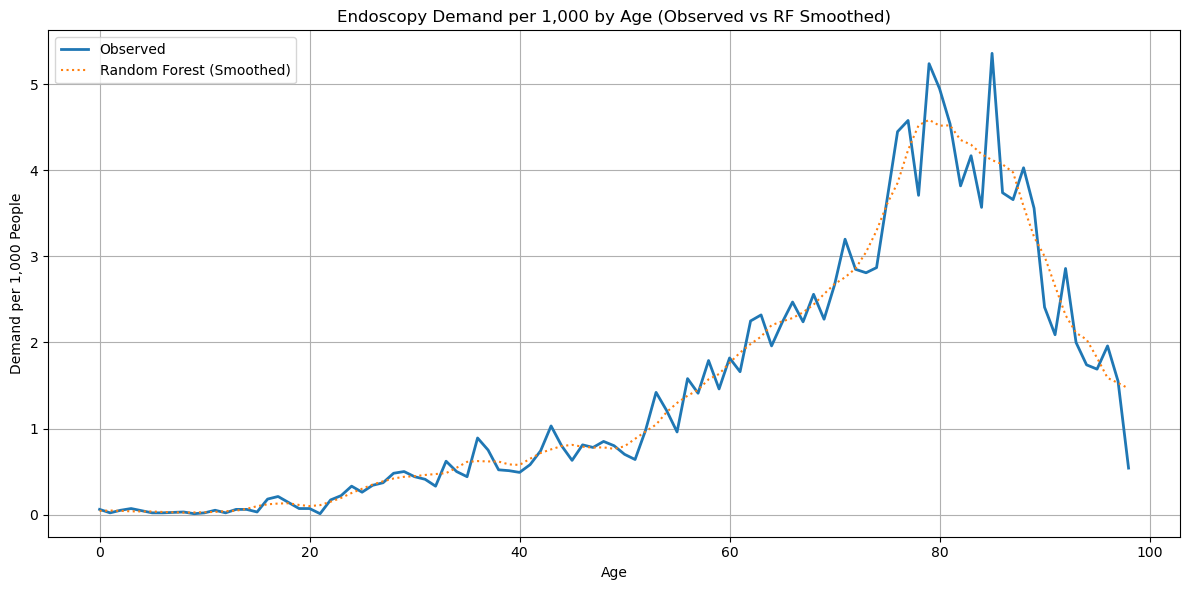

In [251]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming merged_df is your dataframe with 'age' and 'endoscopy_demand_per_1k'

# Prepare data
model_df = merged_df.copy()
model_df.dropna(subset=["endoscopy_demand_per_1k"], inplace=True)

X = model_df[["age"]]
y = model_df["endoscopy_demand_per_1k"]

# Fit Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X, y)
model_df["predicted_rf"] = rf_model.predict(X)

# Apply Moving Average Smoothing (window=5) to RF predictions
window_size = 5
model_df["predicted_rf_smoothed"] = model_df["predicted_rf"].rolling(
    window=window_size, center=True, min_periods=1).mean()

# Evaluation function
def evaluate(true, pred, name):
    mae = mean_absolute_error(true, pred)
    rmse = np.sqrt(mean_squared_error(true, pred))
    r2 = r2_score(true, pred)
    print(f"{name:<20} | MAE: {mae:.2f} | RMSE: {rmse:.2f} | R²: {r2:.3f}")

evaluate(y, model_df["predicted_rf_smoothed"], "Random Forest (Smoothed)")

# Plot observed vs RF predicted (smoothed)
plt.figure(figsize=(12, 6))
sns.lineplot(data=model_df, x="age", y="endoscopy_demand_per_1k", label="Observed", linewidth=2)
sns.lineplot(data=model_df, x="age", y="predicted_rf_smoothed", label="Random Forest (Smoothed)", linestyle=":")
plt.title("Endoscopy Demand per 1,000 by Age (Observed vs RF Smoothed)")
plt.ylabel("Demand per 1,000 People")
plt.xlabel("Age")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


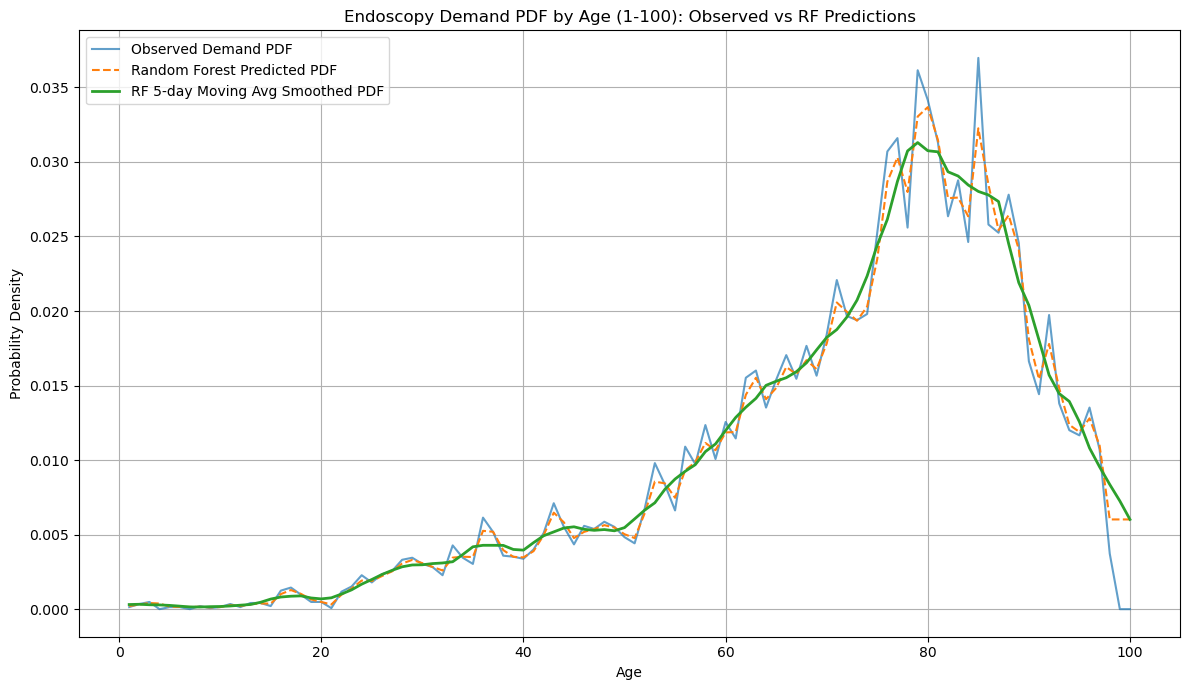

In [257]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

# Prepare full age range and merge observed demand
full_age_range = pd.DataFrame({'age': np.arange(1, 101)})
merged_full = full_age_range.merge(merged_df[['age', 'endoscopy_demand_per_1k']], on='age', how='left')

# Keep only rows where demand is known (non-NaN) for training
train_df = merged_full.dropna(subset=['endoscopy_demand_per_1k'])

# Fit RF on training data
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(train_df[['age']], train_df['endoscopy_demand_per_1k'])

# Predict RF demand over the full age range (including ages with missing demand)
rf_pred = rf_model.predict(full_age_range[['age']])

# Normalize observed and predicted demand for PDF
observed_pdf = merged_full['endoscopy_demand_per_1k'].fillna(0)  # fill NaNs with 0 for plotting
observed_pdf /= observed_pdf.sum()
rf_pdf = rf_pred / rf_pred.sum()

# Apply 5-day moving average smoothing on RF PDF
window_size = 5
rf_pdf_smoothed = pd.Series(rf_pdf).rolling(window=window_size, center=True, min_periods=1).mean()

# Plot all three
plt.figure(figsize=(12, 7))
plt.plot(merged_full['age'], observed_pdf, label='Observed Demand PDF', alpha=0.7)
plt.plot(full_age_range['age'], rf_pdf, label='Random Forest Predicted PDF', linestyle='--')
plt.plot(full_age_range['age'], rf_pdf_smoothed, label='RF 5-day Moving Avg Smoothed PDF', linewidth=2)
plt.xlabel('Age')
plt.ylabel('Probability Density')
plt.title('Endoscopy Demand PDF by Age (1-100): Observed vs RF Predictions')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [259]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

# Assuming these variables are from the previous code:
# observed_pdf (normalized observed demand PDF, NaNs filled with zero)
# rf_pdf (normalized RF predicted demand PDF)
# rf_pdf_smoothed (5-day moving average smoothed RF PDF)

# Calculate 5-day moving average smoothed observed PDF
window_size = 5
observed_pdf_smoothed = pd.Series(observed_pdf).rolling(window=window_size, center=True, min_periods=1).mean()

# Define a function to print metrics
def print_eval_metrics(true, pred, label):
    mae = mean_absolute_error(true, pred)
    rmse = np.sqrt(mean_squared_error(true, pred))
    r2 = r2_score(true, pred)
    print(f"{label}: MAE = {mae:.5f}, RMSE = {rmse:.5f}, R² = {r2:.5f}")

# Evaluate Random Forest predicted PDF vs observed PDF (unsmoothed)
print_eval_metrics(observed_pdf, rf_pdf, "RF Predicted PDF vs Observed PDF")

# Evaluate Random Forest smoothed PDF vs observed PDF smoothed
print_eval_metrics(observed_pdf_smoothed, rf_pdf_smoothed, "RF Smoothed PDF vs Observed Smoothed PDF")

# Evaluate Moving Average smoothed observed PDF vs original observed PDF
print_eval_metrics(observed_pdf, observed_pdf_smoothed, "Observed Smoothed PDF vs Original Observed PDF")


RF Predicted PDF vs Observed PDF: MAE = 0.00071, RMSE = 0.00129, R² = 0.98343
RF Smoothed PDF vs Observed Smoothed PDF: MAE = 0.00033, RMSE = 0.00075, R² = 0.99413
Observed Smoothed PDF vs Original Observed PDF: MAE = 0.00128, RMSE = 0.00198, R² = 0.96100


In [263]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import statsmodels.formula.api as smf

# --- Step 1: Prepare training data (continuous age)
train_df = merged_df[merged_df['age'] <= 84].dropna(subset=["endoscopy_demand_per_1k"]).copy()

# --- Random Forest Model ---
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(train_df[["age"]], train_df["endoscopy_demand_per_1k"])

# --- Poisson GLM Model ---
glm_model = smf.glm(
    formula="endoscopy_demand_per_1k ~ age",
    data=train_df,
    family=sm.families.Poisson()
).fit()

# --- Step 2: Create synthetic LSOA data with ONS age segments and populations ---
age_band_edges = list(range(0, 90, 5)) + [100]  # 0,5,10,...,85,90,100
age_band_labels = [f"{age_band_edges[i]}-{age_band_edges[i+1]-1}" for i in range(len(age_band_edges)-2)] + ["85+"]

lsoa_list = ["LSOA_1", "LSOA_2", "LSOA_3"]
data = []
np.random.seed(42)
for lsoa in lsoa_list:
    for i in range(len(age_band_labels)):
        pop = np.random.randint(50, 500)  # synthetic population per age band
        data.append({
            "LSOA": lsoa,
            "age_band": age_band_labels[i],
            "pop": pop,
            "age_start": age_band_edges[i],
            "age_end": age_band_edges[i+1] - 1 if i < len(age_band_labels)-1 else 100
        })
lsoa_df = pd.DataFrame(data)

# --- Step 3: Prepare prediction ages ---
ages_for_pred = pd.DataFrame({"age": np.arange(0, 85)})

# Predict demand per 1k by age for RF and GLM
ages_for_pred["predicted_rf_demand_per_1k"] = rf_model.predict(ages_for_pred[["age"]])
ages_for_pred["predicted_glm_demand_per_1k"] = glm_model.predict(ages_for_pred)

# --- Step 4: Map predicted demand to age bands by averaging over ages in band ---
def avg_pred_for_band(row, model_col):
    mask = (ages_for_pred["age"] >= row["age_start"]) & (ages_for_pred["age"] <= row["age_end"])
    return ages_for_pred.loc[mask, model_col].mean()

lsoa_df["predicted_rf_per_1k"] = lsoa_df.apply(avg_pred_for_band, axis=1, model_col="predicted_rf_demand_per_1k")
lsoa_df["predicted_glm_per_1k"] = lsoa_df.apply(avg_pred_for_band, axis=1, model_col="predicted_glm_demand_per_1k")

# --- Step 5: Calculate estimated total endoscopy demand per band in each LSOA ---
lsoa_df["estimated_rf_endoscopy_count"] = (lsoa_df["pop"] * lsoa_df["predicted_rf_per_1k"]) / 1000
lsoa_df["estimated_glm_endoscopy_count"] = (lsoa_df["pop"] * lsoa_df["predicted_glm_per_1k"]) / 1000

# --- Step 6: View sample results ---
print(lsoa_df.head(20))

# --- Step 7: Aggregate total demand per LSOA ---
total_demand_per_lsoa = lsoa_df.groupby("LSOA")[["estimated_rf_endoscopy_count", "estimated_glm_endoscopy_count"]].sum().reset_index()

print("\nTotal predicted endoscopy demand per LSOA:")
print(total_demand_per_lsoa)


      LSOA age_band  pop  age_start  age_end  predicted_rf_per_1k  \
0   LSOA_1      0-4  152          0        4              0.04812   
1   LSOA_1      5-9  485          5        9              0.02238   
2   LSOA_1    10-14  398         10       14              0.03886   
3   LSOA_1    15-19  320         15       19              0.12794   
4   LSOA_1    20-24  156         20       24              0.15080   
5   LSOA_1    25-29  121         25       29              0.38698   
6   LSOA_1    30-34  238         30       34              0.47022   
7   LSOA_1    35-39   70         35       39              0.61710   
8   LSOA_1    40-44  152         40       44              0.71462   
9   LSOA_1    45-49  171         45       49              0.77854   
10  LSOA_1    50-54  264         50       54              0.96484   
11  LSOA_1    55-59  380         55       59              1.44960   
12  LSOA_1    60-64  137         60       64              1.98380   
13  LSOA_1    65-69  422         6